In [330]:
import json
import os
import numpy as np
import scipy
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
%matplotlib qt
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pylab
from scipy.ndimage.filters import gaussian_filter
from statistics import mean

In [367]:
humanResultDir = "C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/DownloadedResults"
robotResultDir = "C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/Unity/Project Arena/Assets/Results/ExperimentSamplesMultyTarget1"
robotResultDir2 = "C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/Unity/Project Arena/Assets/Results/ExperimentSamplesMultyTarget"
originalMapDir = "C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/Python"

robotFilePrefix = 'resultPositionNum'
robotFileSuffix = '.json'
humanFilePrefix = 'Result'
humanFileSuffix = 't.txt'

# Metrics

### edit distance
#### number of modification between two path

In [3]:
def levenshtein(s, t):
        #''' From Wikipedia article; Iterative with two matrix rows. '''
    if s == t: return 0
    elif len(s) == 0: return len(t)
    elif len(t) == 0: return len(s)
    v0 = [None] * (len(t) + 1)
    v1 = [None] * (len(t) + 1)
    for i in range(len(v0)):
        v0[i] = i
    for i in range(len(s)):
        v1[0] = i + 1
        for j in range(len(t)):
            cost = 0 if s[i] == t[j] else 1
            v1[j + 1] = min(v1[j] + 1, v0[j + 1] + 1, v0[j] + cost)
        for j in range(len(v0)):
            v0[j] = v1[j]
                
    return v1[len(t)]

### Frechet Distance 
#### length of the shortest leash sufficient for both to traverse their separate paths

In [4]:
def euc_dist(pt1,pt2):
    return scipy.spatial.distance.cdist(pt1, pt2, 'euclidean')[0][0]

In [5]:
def Rescale(path1, path2):
    len1 = len(path1) 
    len2 = len(path2)

    if len1 > len2:
        len_ = len2
        len_max = len1
        path_min = path2 
        path_max = path1
        re_scale_factor = float(len2)/float(len1) 
    else:
        len_ = len1
        len_max = len2
        path_min = path1 
        path_max = path2
        re_scale_factor = float(len1)/float(len2)

    #re-scaling both path
    v = 0.0 
    path1_rescaled = []
    path2_rescaled = []

    #print(str(v) + ", " + str(w))
    while(v < float(len_)):
        path1_rescaled.append(path_min[int(v)])
        v = float(v) + re_scale_factor

    v = 0.0
    while(v < float(len_max)):
        path2_rescaled.append(path_max[int(v)])
        v = v + 1

    #because sometimes one of the path (rescaled) is longer by one than the other, we add to the shortest a copy of the last element
    if(len(path1_rescaled) > len(path2_rescaled)):
        path2_rescaled.append(path2_rescaled[len(path2_rescaled)-1])

    if(len(path2_rescaled) > len(path1_rescaled)):
        path1_rescaled.append(path1_rescaled[len(path1_rescaled)-1])
        
    return path1_rescaled, path2_rescaled

In [6]:
def _c(ca,i,j,p,q):

    x1, y1 = p[i].split(",")
    x2, y2 = q[j].split(",")
    if ca[i,j] > -1:
        return ca[i,j]
    elif i == 0 and j == 0:
        ca[i,j] = euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))])
    elif i > 0 and j == 0:
        ca[i,j] = max( _c(ca,i-1,0,p,q), euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))]))
    elif i == 0 and j > 0:
        ca[i,j] = max( _c(ca,0,j-1,p,q), euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))]))
    elif i > 0 and j > 0:
        ca[i,j] = max(                                                     
            min(                                                           
                _c(ca,i-1,j,p,q),                                          
                _c(ca,i-1,j-1,p,q),                                        
                _c(ca,i,j-1,p,q)                                           
            ),                                                             
            euc_dist([(int(x1),int(y1))], [(int(x2),int(y2))])                                           
            )                                                          
    else:
        ca[i,j] = float('inf')

    return ca[i,j]

In [7]:
def frechetDist(p,q):
    
    p, q = Rescale(p,q)
    len_p = len(p)
    len_q = len(q)


    if len_p == 0 or len_q == 0:
        raise ValueError('Input curves are empty.')

    if len_p != len_q or len(p[0]) != len(q[0]):
        raise ValueError('Input curves do not have the same dimensions.')

    ca    = ( np.ones((len_p,len_q), dtype=np.float64) * -1 ) 
    dist = _c(ca,len_p-1,len_q-1,p,q)

    return dist

### Longest Common Subsequence

In [8]:
def lcs(a, b):
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    # read the substring out from the matrix
    result = ""
    x, y = len(a), len(b)
    while x != 0 and y != 0:
        if lengths[x][y] == lengths[x-1][y]:
            x -= 1
        elif lengths[x][y] == lengths[x][y-1]:
            y -= 1
        else:
            assert a[x-1] == b[y-1]
            result = a[x-1] + result
            x -= 1
            y -= 1
    return result

### ERP - edit distance with real penalty

In [9]:
def e_erp(t0,t1,g):
    """
    Usage
    -----
    The Edit distance with Real Penalty between trajectory t0 and t1.

    Parameters
    ----------
    param t0 : len(t0)x2 numpy_array
    param t1 : len(t1)x2 numpy_array

    Returns
    -------
    dtw : float
          The Dynamic-Time Warping distance between trajectory t0 and t1
    """

    n0 = len(t0)
    n1 = len(t1)
    C=np.zeros((n0+1,n1+1))

    t0_float = []
    t1_float = []

    k = 0
    while(k < n0):
        pos1 = t0[k]
        #pos2 = t1[k]
        x1, y1 = pos1.split(",")
        #x2, y2 = pos2.split(",")
        coord1 = [(float(x1), float(y1))]
        #coord2 = [(float(x2), float(y2))]
        t0_float.append(coord1)
        #t1_float.append(coord2)
        k = k + 1

    k = 0
    while(k < n1):
        #pos1 = t0[k]
        pos2 = t1[k]
        #x1, y1 = pos1.split(",")
        x2, y2 = pos2.split(",")
        #coord1 = [(float(x1), float(y1))]
        coord2 = [(float(x2), float(y2))]
        #t0_float.append(coord1)
        t1_float.append(coord2)
        k = k + 1
    
    #print(str(len(t0)) + ", " + str(len(t1)))

    C[1:,0]=sum(map(lambda x : abs(euc_dist(g,x)),t0_float))
    C[0,1:]=sum(map(lambda y : abs(euc_dist(g,y)),t1_float))
    for i in np.arange(n0)+1:
        for j in np.arange(n1)+1:
            derp0 = C[i-1,j] + euc_dist(t0_float[i-1],g)
            derp1 = C[i,j-1] + euc_dist(g,t1_float[j-1])
            derp01 = C[i-1,j-1] + euc_dist(t0_float[i-1],t1_float[j-1])
            C[i,j] = min(derp0,derp1,derp01)
    erp = C[n0,n1]
    return erp

# compare paths with DTW

### some conversion functions

In [10]:
# this function is used to convert the positions stored in database into normal coordinates
def rotate(x, y, origin, mapName):
    
    # shift to origin
    x1 = x #- origin[0]
    y1 = y #- origin[1]

    #rotate
    x2 = y1
    y2 = -x1
    
    # shift back
    x3 = x2
    if mapName == "uffici2.map":
        y3 = y2 +53
    if mapName == "open2.map":
        y3 = y2 +57
    if mapName == "open1.map":
        y3 = y2 +48
    if mapName == "uffici1.map":
        y3 = y2 +54 

    return x3, y3

In [11]:
# separate the position stored into array of position x and position y
def conv2Axis(coordinateArray):
    """
    input: array_position = ["pos_x, pos_y", ...]
    output: [pos_x, ...], [pos_y, ...]
    """
    res_x = []
    res_y = []
    for i in coordinateArray:

        res_x = np.append(res_x, i[0])
        res_y = np.append(res_y, i[1])
        
    
    return res_x, res_y

In [12]:
# convert the trajectory stored into a array of arrays of converted position
def stringArray2listArrayOfMap(target, origin, mapName):
    """
    input:  target = ["pos_x, pos_y", ...]
            origin = [pos_x, pos_y] the origin point of map
            mapName = "uffici2.map" or "open2.map" or "open1.map" or "uffici1.map"
    output: [[pos_x, posy], ...]
    """
    res = [[]]
    
    for i in range(len(target)):
        a, b = target[i].split(",")
        a, b = rotate(int(a),int(b), origin, mapName)
        
        if len(res[0]) == 0:
            res = [[int(a), int(b)]]
        else:
            res = np.append(res, [[int(a), int(b)]], axis=0)
    
    return res

In [13]:
def getOriginalMap(mapName):
    if mapName == "open1.map":
        originalMapFile = "open1PythonFormat.map.txt"
    if mapName == "open2.map":
        originalMapFile = "open2PythonFormat.map.txt"
    if mapName == "uffici1.map":
        originalMapFile = "uffici1PythonFormat.map.txt"
    if mapName == "uffici2.map":
        originalMapFile = "uffici2PythonFormat.map.txt"
        
    return originalMapFile      

In [14]:
# return the ration of number of points that have distance within the threshold and entire elements in array 
def similarPercentage(dtw_path, path1, path2, threshold = 4):
    """
    input:  dtw_path: [[index_path1, index_path2], ...]
            path1: first trajectory
            path2: second trajectory
            threshold: value limit to consider two points as similar
    """
    count = 0.0
    for i in dtw_path:
        distance = euclidean(path1[i[0]], path2[i[1]])
        
        if distance < threshold:
            count += 1
    
    return count / len(dtw_path)
        

###  functions to draw similar part between paths

In [15]:
# get array of arrays of map from originalMapFile
def getOriginalMapMatrix(mapName):
    """
    input: mapName = "uffici2.map" or "open2.map" or "open1.map" or "uffici1.map"
    output: array of arrays of int
    """
    originalMapFile = getOriginalMap(mapName)
    if os.path.isfile(originalMapDir + "/" + originalMapFile):
        with open(originalMapDir + "/" + originalMapFile) as f:
            array = []
            content = f.readlines()

            content = [x.strip() for x in content]

            mapMatrix = [[]]
            for line in content:
                array = line.split(',')
                array_line =[]
                for i in range(len(array)):
                    a = int(array[i])
                    array_line = np.append(array_line, a)
                    
                if len(mapMatrix[0]) == 0:
                    mapMatrix = np.array([array_line])
                else:
                    mapMatrix = np.insert(mapMatrix, 0, array_line, axis=0)
                    
            return mapMatrix

In [16]:
# put value of similarity at coordinate position of mapMatrix
def putSimilarityValue(similarity, mapMatrix, coordinate):
    x = coordinate[0]
    y = coordinate[1]
    
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            if x + j >= 0 and x + j < len(mapMatrix[0]) and y + i >= 0 and y + i < len(mapMatrix):
                a = mapMatrix[y + i][x + j]
            
                # if cell is not wall
                if a != 1 and a != 4:
                    # if new similarity is close than previous number, then substitute it
                    if similarity > a:
                        mapMatrix[y + i][x + j] = similarity
    

In [17]:
# determine and put the similar value into matrix
def mostSimilarPart(mapMatrix, first_path, second_path, dtw_path):
    
    for i in dtw_path:
        distance = euclidean(first_path[i[0]], second_path[i[1]])
        
        # use number that is guaranteed to be larger than other number already in map  
        if distance >= 0 and distance < 2:
            similarity = 3
        if distance >= 2 and distance < 4:
            similarity = 2
        if distance >= 4 and distance < 6:
            similarity = 1
        if distance >= 6:
            similarity = 0
        
        putSimilarityValue(similarity, mapMatrix, first_path[i[0]])
        putSimilarityValue(similarity, mapMatrix, second_path[i[1]])
        

In [18]:
def smoothHeatMap(heatMap, bins=100, sigma=3):
    x = []
    y = []
    for row in range(len(heatMap)):
        for col in range(len(heatMap[row])):

            while heatMap[row][col] > 0:
                x.append(col)
                y.append(row)
                heatMap[row][col] -=1

    H, xedges, yedges = np.histogram2d(x, y, bins=bins)
    # our map start with row = 1
    extent = [0, len(heatMap[0])-1, 1, len(heatMap)]
    H = gaussian_filter(H.T, sigma=sigma)
    
    return H, extent

### draw the paths

In [427]:
def drawPath(firstPath, secondPath, plot=True, plot_dtw=False, plot_similarity=False, label_first='first', label_second='second', show_text=False, robot=""):
    """
    input:  firstPath, secondPath: trajectories
            plot: bool, if you want to plot the graph, if false all argument of plot below will be disabled
            plot_dtw: bool, if you want to plot the connection of dtw
            plot_similarity: bool, plot the heatmap
            label_first: string, label of firstPath
            label_second: string, label of secondPath
            show_text: bool, print the distances on console
            robot: "first" or "second", identify if one of firstPath or secondPath is a robot exploration
    """
    title = ''
    if os.path.isfile(firstPath):
        with open(firstPath) as pathFile:
            firstData = json.load(pathFile)
            mapName = firstData["mapName"]
            first_array_position = firstData["position"]
            
            if robot == 'first':
                alpha = firstData['alpha']
                beta = firstData['beta']
                delta = firstData['delta']
                title = 'Alpha: {:.2f} , Beta: {:.2f} , Delta: {:.2f}'.format(alpha, beta, delta)
            
            firstMapFile = getOriginalMap(mapName)
                
    if os.path.isfile(secondPath):
        with open(secondPath) as pathFile:
            data = json.load(pathFile)
            mapName = data["mapName"]
            second_array_position = data["position"]
            
            if robot == 'second':
                alpha = data['alpha']
                beta = data['beta']
                delta = data['delta']
                title = 'Alpha: {:.2f} , Beta: {:.2f} , Delta: {:.2f}'.format(alpha, beta, delta)
            
            secondMapFile = getOriginalMap(mapName)
                
    if firstMapFile != secondMapFile:
        return print("two paths must be on the same map")   
    
    
    
    # compute other distance metrics
    distanceL = levenshtein(first_array_position, second_array_position)
    distanceERP = e_erp(first_array_position, second_array_position, np.zeros((1, 2), dtype=float))
    distanceF = frechetDist(first_array_position, second_array_position)
    distanceLCS = len(lcs(first_array_position, second_array_position))
    
    # compute dtw distance metrics
    origin = (0.0,0.0)
    first_array_position = stringArray2listArrayOfMap(first_array_position, origin, mapName)
    second_array_position = stringArray2listArrayOfMap(second_array_position, origin, mapName)
    distanceDTW, pathDTW = fastdtw(first_array_position, second_array_position, dist=euclidean)
    similarityDTW = similarPercentage(pathDTW, first_array_position, second_array_position) * 100
    
    if show_text:
        print("total dtw distance between two paths = %.2f" %distanceDTW)
        print("similarity percentage = %.2f%%" %(similarityDTW))
        print("edit distance between two paths = %.2f" %distanceL)
        print("ERP distance between two paths = %.2f" %distanceERP)
        print("Frechet distance between two paths = %.2f" %distanceF)
        print("LCSS distance between two paths = %.2f" %distanceLCS)
        

    
    if plot:
        plt.figure(figsize=(6.4, 4.8))
        # draw similarity part
        mapMatrix = getOriginalMapMatrix(mapName)
        
        if plot_similarity:
            heatMapMatrix = np.zeros(shape=(len(mapMatrix), len(mapMatrix[0])))
            
            mostSimilarPart(heatMapMatrix, first_array_position, second_array_position, pathDTW)    
            im, extent = smoothHeatMap(heatMapMatrix)
            plt.imshow(im, extent=extent, origin = 'lower',cmap='autumn_r')
         

        # draw the original map
        for i in range(len(mapMatrix)):
            for j in range(len(mapMatrix[i])):
                a = mapMatrix[i][j]
                if a == 1:
                    # +1 because we suppose the row start from index 1
                    plt.plot(j, i+1, 'ks')                    
                if a == 4:
                    plt.plot(j, i+1 , 'gs')
        
        #draw the paths

        first_x, first_y = conv2Axis(first_array_position)
        second_x, second_y = conv2Axis(second_array_position)


        plt.plot(first_x, first_y, 'r-', label=label_first)
        plt.plot(second_x, second_y, 'b-', label=label_second)

        # draw DTW lines 
        if plot_dtw:
            for i in pathDTW:
                fx, fy = first_array_position[i[0]]
                sx, sy = second_array_position[i[1]] 
                plt.plot([fx, sx], [fy, sy], 'g-')
        
        plt.text(len(mapMatrix[0])-10, len(mapMatrix)-5, 
                 "ERP={:.2f}\nDTW={:.2f}\nSimilarity={:.2f}%".format(distanceERP,distanceDTW,similarityDTW),
                color='r', bbox = dict(facecolor = "w", alpha = 0.9))
        plt.legend(loc=3)
        plt.grid(False)
        plt.savefig("C:/Users/ZhanYuan/Desktop/polimi/magistrale", dpi = 50, bbox_inches = "tight")
        plt.title(title, fontsize=8)
        plt.show()

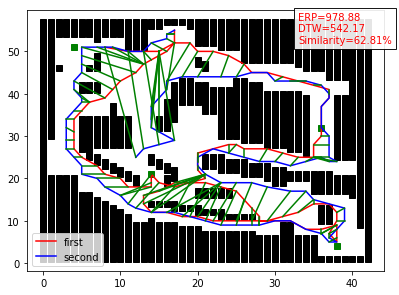

In [428]:
drawPath(humanResultDir+"/Result6t.txt", humanResultDir+"/Result10t.txt", plot_dtw=True)

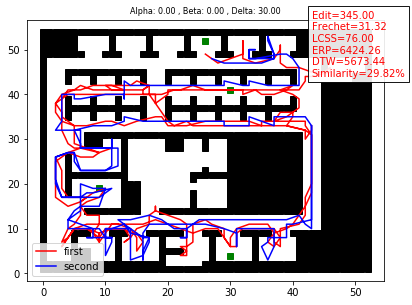

In [209]:
drawPath(humanResultDir+"/Result12t.txt", robotResultDir+"/resultPositionNum1.json", plot_dtw=False, robot='second')

total dtw distance between two paths = 542.17
similarity percentage = 62.81%
edit distance between two paths = 96.00
ERP distance between two paths = 978.88
Frechet distance between two paths = 26.31
LCSS distance between two paths = 76.00


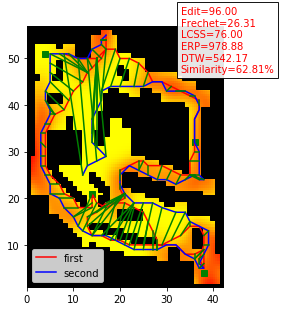

In [40]:
%matplotlib inline
drawPath(humanResultDir+"/Result6t.txt", humanResultDir+"/Result10t.txt", plot_dtw=True, plot_similarity=True)

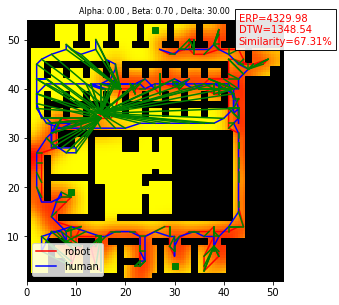

In [429]:
drawPath(robotResultDir+"/resultPositionNum78.json", humanResultDir+"/Result22t.txt", plot_dtw=True, plot_similarity=True, label_first='robot', label_second='human', robot='first')

# Find most similar path

In [218]:
def findMostSimilarPath(filePath, plot=True, plot_dtw=False, plot_similarity=False, label_fst='first', label_sec='second'):
    """
    input:  filePath: robot trajectories
            plot: bool, if you want to plot the graph, if false all argument of plot below will be disabled
            plot_dtw: bool, if you want to plot the connection of dtw
            plot_similarity: bool, plot the heatmap
            label_fst: string, label of firstPath
            label_sec: string, label of secondPath
            show_text: bool, print the distances on console
            robot: "first" or "second", identify if one of firstPath or secondPath is a robot exploration
    """
    if os.path.isfile(filePath):
        with open(filePath) as file:
            data = json.load(file)
            mapName = data["mapName"]
            array_position = data["position"]
            mapFile = getOriginalMap(mapName)
            
    origin = (0.0,0.0)
    array_position = stringArray2listArrayOfMap(array_position, origin, mapName)
        
    min_distance = float('Inf') 
    max_similarity = 0
    mostSimilarFile = ""
    mostCloseFile = ""
    
    index = 1
    finish = False 
    while not finish:
        humanPath = humanResultDir + "/" + humanFilePrefix + str(index) + humanFileSuffix
        if os.path.isfile(humanPath):
            if filePath != humanPath:
                with open(humanPath) as human_file:
                    human_data = json.load(human_file)
                    if(human_data['mapName'] == mapName):
                        human_position = human_data['position']

                        human_position = stringArray2listArrayOfMap(human_position, origin, mapName)
                        distance, path = fastdtw(array_position, human_position, dist=euclidean)
                        similarity = similarPercentage(path, array_position, human_position)

                        if distance < min_distance:
                            min_distance = distance
                            mostCloseFile = humanPath
                            mostClosePath = human_position
                            close_dtw_path = path

                        if similarity > max_similarity:
                            max_similarity = similarity
                            mostSimilarFile = humanPath
                            mostSimilarPath = human_position
                            similar_dtw_path = path
                        
            index = index + 1
        else:
            finish = True
            
    #print("most close file: %s with distance %.2f" %(mostCloseFile, min_distance))
    #print("most similar file: %s with similarity %.2f%%" %(mostSimilarFile, max_similarity * 100))
    
    if plot: 
    
        if os.path.isfile(originalMapDir + "/" + mapFile):
            with open(originalMapDir + "/" + mapFile) as f:
                array = []
                content = f.readlines()
                content = [x.strip() for x in content]
                
        c = 1
        plt.figure(figsize=(13, 4))
        for drawline in [[mostClosePath, close_dtw_path], [mostSimilarPath, similar_dtw_path]]:
            plt.subplot(1, 2, c)
            
            # draw similarity part
            mapMatrix = getOriginalMapMatrix(mapName)
            if plot_similarity:      
                heatMapMatrix = np.zeros(shape=(len(mapMatrix), len(mapMatrix[0])))

                mostSimilarPart(heatMapMatrix, array_position, drawline[0], drawline[1])    
                im, extent = smoothHeatMap(heatMapMatrix)
                plt.imshow(im, extent=extent, origin = 'lower',cmap='autumn_r')
            
            # draw the original map
            j = 0
            for line in content:
                array = line.split(',')
                for i in range(len(array)):
                    a = int(array[i])
                    if a == 1:
                        plt.plot(i, len(content)-j, 'ks')

                    if a == 4:
                        plt.plot(i, len(content)-j , 'gs')

                j = j + 1 

            #draw the paths

            first_x, first_y = conv2Axis(array_position)
            second_x, second_y = conv2Axis(drawline[0])

            plt.plot(first_x, first_y, 'r-',label=label_fst)
            plt.plot(second_x, second_y, 'b-', label=label_sec)

            # draw DTW lines
            if plot_dtw:
                for i in drawline[1]:
                    fx, fy = array_position[i[0]]
                    sx, sy = drawline[0][i[1]]

                    plt.plot([fx, sx], [fy, sy], 'g-')
            
            plt.legend(loc=3)
            if c == 0:
                plt.title("most close")
            else:
                plt.title("most similar")
            c += 1          
            
        plt.show()
        
    return [mostCloseFile, min_distance], [mostSimilarFile, max_similarity * 100]

(['C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/DownloadedResults/Result10t.txt',
  542.1732381680359],
 ['C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/DownloadedResults/Result2t.txt',
  63.94557823129252])

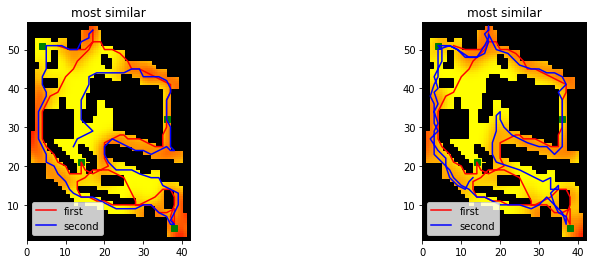

In [197]:
%matplotlib notebook
findMostSimilarPath(humanResultDir+"/Result6t.txt",plot_similarity=True)

In [315]:
def mostHumanLikePaths(robortDir):
    most_close_dict = {}
    most_similar_dict = {}
    distance_param = {}
    similarity_param = {}
    
    index_robort = 1
    finish_robort = False
    while not finish_robort:
        robortFile = robortDir + "/" + robotFilePrefix + str(index_robort) + robotFileSuffix
        if os.path.isfile(robortFile):
            with open(robortFile) as file:
                data=json.load(file)
                mapName = data["mapName"]
                array_position = data["position"]
                alpha = round(data['alpha'], 4)
                beta = round(data['beta'], 4)
                delta = data['delta']
                time = data['time']
                
                mapFile = getOriginalMap(mapName)

                origin = (0.0,0.0)
                array_position = stringArray2listArrayOfMap(array_position, origin, mapName)
                
                min_distance = float('Inf') 
                max_similarity = 0
                mostSimilarFile = ""
                mostCloseFile = ""
                index_human = 1
                finish_human = False 
                while not finish_human:
                    humanFile = humanResultDir + "/" + humanFilePrefix + str(index_human) + humanFileSuffix

                    if os.path.isfile(humanFile):
                        with open(humanFile) as human_file:

                            human_data = json.load(human_file)
                            if(human_data['mapName'] == mapName):
                                
                                human_position = human_data['position']

                                human_position = stringArray2listArrayOfMap(human_position, origin, mapName)
                                distance, path = fastdtw(array_position, human_position, dist=euclidean)
                                similarity = similarPercentage(path, array_position, human_position) * 100
                                
                                if distance < min_distance:
                                    min_distance = distance
                                    mostCloseFile = humanFile
                                    mostClosePath = human_position
                                    close_dtw_path = path

                                if similarity > max_similarity:
                                    max_similarity = similarity
                                    mostSimilarFile = humanFile
                                    mostSimilarPath = human_position
                                    similar_dtw_path = path


                        index_human += 1
                    else:
                        finish_human = True
                    
            if min_distance in most_close_dict:
                most_close_dict[min_distance] = np.append(most_close_dict[min_distance], [[robortFile, mostCloseFile]], axis=0)
            else:
                most_close_dict[min_distance] = [[robortFile, mostCloseFile]]
                
            if max_similarity in most_similar_dict:
                most_similar_dict[max_similarity] = np.append(most_similar_dict[max_similarity], [[robortFile, mostSimilarFile]], axis=0)
            else:
                most_similar_dict[max_similarity] = [[robortFile, mostSimilarFile]]
                
            if time > 0:
                if tuple([alpha, beta]) not in distance_param:
                    distance_param[tuple([alpha, beta])] = [min_distance]
                    similarity_param[tuple([alpha, beta])] = [max_similarity]
                else:
                    distance_param[tuple([alpha, beta])] = np.append(distance_param[tuple([alpha, beta])], min_distance)
                    similarity_param[tuple([alpha, beta])] = np.append(similarity_param[tuple([alpha, beta])], max_similarity)
                
            index_robort += 1
        else:
            finish_robort = True
    return most_close_dict, most_similar_dict, distance_param, similarity_param

In [316]:
distance_dict, similarity_dict, rel_dist_param, rel_similar_param = mostHumanLikePaths(robotResultDir)

In [286]:
distance_dict_sorted = sorted(distance_dict.items(), key=lambda kv: kv[0])
similarity_dict_sorted = sorted(similarity_dict.items(), key=lambda kv: kv[0])[::-1]

In [423]:
def drawCloseAndSimilarPath(distance_dict, similar_dict, top):
    for i in distance_dict[:top]:
        #print(i)
        for j in similar_dict[:top]:
            #print(j)
            for z in range(len(i[1])):
                #print(" z = " , z)
                for w in range(len([j[1]])):
                    #print(" w = ", w)
                    #print(i[1][z] in j[1])
                    if i[1][z] in j[1]:
                        print(i[1][z], j[1])
                        #print(i[1])
                        drawPath(i[1][z][0], i[1][z][1], plot_dtw=False, plot_similarity=True, label_first='robot', label_second='human', robot='first')
                    

['C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/Unity/Project Arena/Assets/Results/ExperimentSamplesMultyTarget1/resultPositionNum78.json', 'C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/DownloadedResults/Result22t.txt'] [['C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/Unity/Project Arena/Assets/Results/ExperimentSamplesMultyTarget1/resultPositionNum78.json', 'C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/DownloadedResults/Result22t.txt']]
['C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/Unity/Project Arena/Assets/Results/ExperimentSamplesMultyTarget1/resultPositionNum329.json', 'C:/Users/ZhanYuan/Desktop/polimi/magistrale/Tesi/MyLocalProject/human-and-robotic-exploration/DownloadedResults/Result22t.txt'] [['C:/Users/ZhanYuan/Desktop/polimi/magistrale

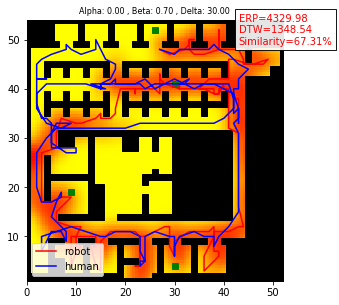

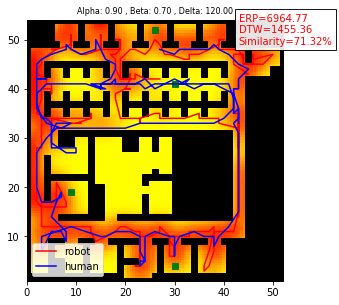

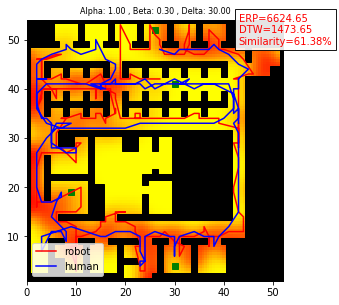

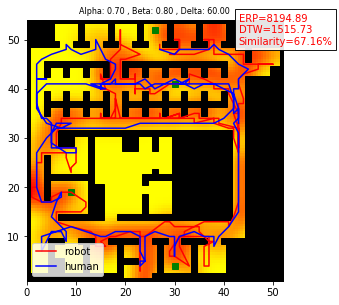

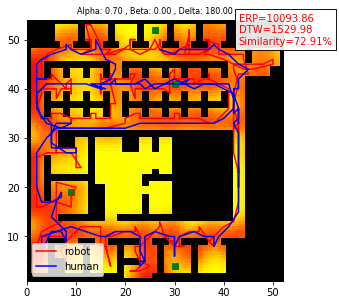

In [430]:
drawCloseAndSimilarPath(distance_dict_sorted, similarity_dict_sorted, top=10)

In [335]:
def distanceMatrix(distance_dict, distance_dict2):
    res = np.zeros((11, 11))
    for i in distance_dict :
        x = int(i[0] * 10)
        y = int(i[1] * 10)
        res[y][x] = mean(distance_dict[i])
    
    return res

In [417]:
p1 = distanceMatrix(rel_dist_param)

([<matplotlib.axis.YTick at 0xef51526550>,
 <a list of 11 Text yticklabel objects>)

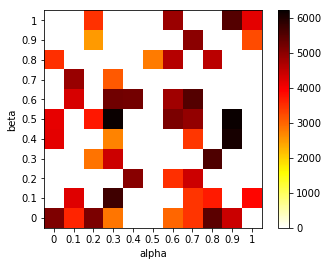

In [366]:
plt.imshow(p1, cmap='hot_r',origin='lower')
plt.show()
plt.colorbar()
plt.xlabel("alpha")
plt.ylabel("beta")
plt.xticks(np.arange(len(p1)),[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.yticks(np.arange(len(p1)),[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])